# Assignment 5. Tools for Machine Learning Workflow

*Foundations of Data Science*  
*Dr. Khalaj (Fall 2023)*  

*For your questions refer to @amirsoleix on Telegram*

### Description  
One of the applications that rises frequently in machine learning projects is classification. A sector where intensively uses classification is retrieval on large data banks mostly by using queries on the previously categorized data. For example, indexing in search engines helps fast retrieval of relevant data, or in e-commerce platforms, appropriate categorization and placement of filters is necessary for better user experience. It allows customers to access their relevant goods with ease, making the platform more profitable.  

In this homework, we want to classify the software, games, etc. available on `downloadha.com`. The website started as a modest delivery network for software, but has since evolved into a precious repository for all kinds of applications for different operating systems and platforms.  

### Information  
Complete the information box below.

In [ ]:
full_name = 'Ilia Hashemi Rad'
student_id = '99102456'

## 1 Retrieval of Data

Consider a content delivery website. On the user end, when you want to find what you want in such websites, you probably use the search bar or the navigation menu on the top, or alternatively, let Google find you the best matching result using its proprietary indexing (which by the way, usually works better than the website's own search bar!).  

But as a data engineer, the level of detail and comprehensiveness of data matters more as you are looking for insight rather than single matches. It allows you to analyze different aspects of social behavior on different localities and make informed decisions based on that.  

Consider that you are a data analyst for a software team given the task of analyzing market demand for your upcoming product. In this scenario, one of the best ways is to track activity on forums and goto places where people get their software from. This can range from different online stores and websites, to community forums and related social media posts.  

After discussion, you have found that `downloadha.com` is one of the main sources local people use for downloading their software hence you want to analyze the demand for different categories of softwares.

### 1.1 Data Version Control
Since data is constantly changing, logging the current state of the data is a necessity. It is required that we track the changes and act upon them when necessary, and a prerequisite to knowing when changes occur is to be aware of what changes are logged in our systems and what changes are not. One of the tools used for version controlling the data is `DVC`. Read the documents and use it in the process.

### 1.2 Crawling

List the information related to each software for the last 1000 softwares listed on the mentioned website. The website uses pagination with 10 results available on each page. So for reaching 1000 softwares you need to crawl `downloadha.com/page/1/` up to `downloadha.com/page/100/`. For having a safety threshold in case of crawler failure (a common problem in crawlers), you can extend it to 2000 items to be sure you are left with 1000 decent instances.  

This website is chosen in particular for its easy access to database. Remember that as systems gets more advanced accessing older data becomes harder. For comparison try to search for books that were listed on Amazon before 2020 and look at the URL!  

The data for each software should include:
- Name
- Platform
- Category and Subcategories
- Description
- Date of Creation
- Author
- Visit Count
- Comment Count
- Tags

Save the data on a CSV file and upload it with your delivery. You can use libraries like Beautiful Soup and Scrapy for the crawling task.

In [ ]:
import requests
from bs4 import BeautifulSoup
import random
import csv
from unidecode import unidecode
from persiantools.jdatetime import JalaliDate
import googletrans

# Create a translator object
translator = googletrans.Translator()

def extract_game_info(article):
    try:
        # Extracting Name
        name = article.find('h2', class_='entry-title').text.strip().replace('دانلود ', '')
        #name = article.find('h2', class_='entry-title').find('a')['href'].split("/")[-2]

        # Extracting Category and Subcategories
        categories = [cat.text.strip() for cat in article.find('div', class_='post-categories').find_all('a', rel='category tag')]

        # Extracting Platform
        if 'بازی کامپیوتر' in categories:
            platform = 'PC'
            categories.remove('بازی کامپیوتر')
        elif 'بازی PS4' in categories:
            platform = 'PS4'
            categories.remove('بازی PS4')
        elif 'بازی PS5' in categories:
            platform = 'PS5'
            categories.remove('بازی PS5')
        elif 'مالتی مدیا' in categories:
            platform = 'Multimedia'
            categories.remove('مالتی مدیا')
        elif 'مجله' in categories:
            platform = 'Journal'
            categories.remove('مجله')
        elif 'نرم افزار' in categories:
            platform = 'Software'
            categories.remove('نرم افزار')
        elif 'والپیپر' in categories:
            platform = 'Wallpaper'
            categories.remove('والپیپر')
        else:
            platform = 'Unknown'

        # Translating Categories into English
        categories = [translator.translate(category, src='fa', dest="en").text for category in categories]

        # Extracting Description
        description = article.find('div', class_='entry-content').find('p', style='text-align: justify;').text.strip()
        description = translator.translate(description, src='fa', dest="en").text

        # Extracting Date of Creation and Author
        date_author_tag = article.find('div', class_='post-date inline-block')
        date = date_author_tag.find('time', class_='entry-date published')['datetime']
        date = date[:date.find('T')]  # Remove the English part

        # Convert Persian date to Gregorian date
        persian_date = JalaliDate(int(date[:4]), int(date[5:7]), int(date[8:10]))
        gregorian_date = persian_date.to_gregorian()

        author = date_author_tag.find('span', class_='author vcard').text.strip()

        visit_and_comment = article.find_all('div', class_='post-view inline-block')

        # Extracting Visit Count
        visit_count = int(visit_and_comment[0].text.strip('بازدید').replace(',', '').replace('\n', '').replace('بازدید', ''))

        # Extracting Comment Count
        comment_count_tag = visit_and_comment[1].find('small')
        comment_count = comment_count_tag.find('a').text.strip() if comment_count_tag else 0

        if comment_count == 'بدون نظر':
            comment_count = 0
        elif comment_count == 'یک نظر':
            comment_count = 1
        else:
            comment_count = unidecode(comment_count.replace(' نظر', '')).replace(',', '')

        # Extracting Tags
        tags = [tag.text.strip() for tag in article.find('div', class_='post-tags').find_all('a', rel='tag')]

        return {
            'Name': name,
            'Platform': platform,
            'Categories': ', '.join(categories),
            'Description': description,
            'Date of Creation': gregorian_date,
            'Author': author,
            'Visit Count': visit_count,
            'Comment Count': comment_count,
            'Tags': ', '.join(tags)
        }
    except Exception as e:
        print(f"Error extracting information: {e}")
        return None

def scrape_and_save_to_csv(base_url, num_pages, output_filename):
    user_agent_list = []

    with open('UserAgents.txt', 'r') as file:
        user_agent_list = file.read().splitlines()

    with open(output_filename, 'w', newline='', encoding='utf-8-sig') as csvfile:
        fieldnames = ['Name', 'Platform', 'Categories', 'Description', 'Date of Creation', 'Author',
                      'Visit Count', 'Comment Count', 'Tags']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for page_num in range(1, num_pages + 1):
            url = f"{base_url}/page/{page_num}/"
            user_agent = random.choice(user_agent_list)
            headers = {'User-Agent': user_agent}

            response = requests.get(url, headers=headers)
            soup = BeautifulSoup(response.content, 'html.parser')

            game_articles = soup.find_all('article', class_='panel')

            for article in game_articles:
                game_info = extract_game_info(article)
                if game_info:
                    writer.writerow(game_info)

# Specify the base URL and the number of pages to scrape
base_url = "https://www.downloadha.com"
num_pages = 200
output_filename = "game_data.csv"

# Call the function to scrape and save to CSV
scrape_and_save_to_csv(base_url, num_pages, output_filename)


### 1.3 Database (Bonus)  
Use a relational database like MySQL, SQLite or a non-relational instance like MongoDB for archiving the data. You don't need online implementation of this and can create a local instance of database and upload the relevant files with your delivery.

In [30]:
import sqlite3
import pandas as pd

# Load csv file into a pandas DataFrame
df = pd.read_csv('game_data.csv')

df = df.drop(index=1383)

# Create a connection to a SQLite database
conn = sqlite3.connect('download_data_DB.db')

# Define schema for the Downloads table
downloads_schema = """
CREATE TABLE IF NOT EXISTS Downloads (
    Name TEXT,
    Download_id INTEGER PRIMARY KEY,
    Platform_id INTEGER,
    Categories_ids TEXT,
    Description TEXT,
    Date TEXT,
    Author_id INTEGER,
    Visit_count INTEGER,
    Comment_count INTEGER,
    Tags TEXT
)
"""

# Define schema for the Platforms table
platforms_schema = """
CREATE TABLE IF NOT EXISTS Platforms (
    name TEXT,
    Platform_id INTEGER PRIMARY KEY
)
"""

# Define schema for the Categories table
categories_schema = """
CREATE TABLE IF NOT EXISTS Categories (
    name TEXT,
    Category_id INTEGER PRIMARY KEY
)
"""

# Define schema for the Authors table
authors_schema = """
CREATE TABLE IF NOT EXISTS Authors (
    name TEXT,
    Author_id INTEGER PRIMARY KEY
)
"""

# Execute schema creation queries
conn.execute(downloads_schema)
conn.execute(platforms_schema)
conn.execute(categories_schema)
conn.execute(authors_schema)

# Create counters for each id
Download_id_counter = 1
Platform_id_counter = 1
Category_id_counter = 1
Author_id_counter = 1

# Create dictionaries to store the ids
Platforms_dict = {}
categories_dict = {}
Authors_dict = {}

# Iterate over each row of the DataFrame
for index, row in df.iterrows():
    # Get the Platform, categories, and Author from the row
    Platform_name = row['Platform']

    categories_names = row['Categories'].split(', ')
    Author_name = row['Author']

    # Do the same for the Platform and Author
    if Platform_name not in Platforms_dict:
        Platforms_dict[Platform_name] = Platform_id_counter
        conn.execute("INSERT INTO Platforms VALUES (?, ?)", (Platform_name, Platform_id_counter))
        Platform_id_counter += 1

    if Author_name not in Authors_dict:
        Authors_dict[Author_name] = Author_id_counter
        conn.execute("INSERT INTO Authors VALUES (?, ?)", (Author_name, Author_id_counter))
        Author_id_counter += 1

    # For the categories, iterate over each one
    categories_ids = []
    for Category_name in categories_names:
        # If the Category is not in the dictionary, add it and increment the counter
        if Category_name not in categories_dict:
            categories_dict[Category_name] = Category_id_counter
            conn.execute("INSERT INTO Categories VALUES (?, ?)", (Category_name, Category_id_counter))
            Category_id_counter += 1
        # Add the id to the list of Category ids for this row
        categories_ids.append(categories_dict[Category_name])

    # Insert the row into the Download table
    conn.execute("""
    INSERT INTO Downloads VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (row['Name'], Download_id_counter, Platforms_dict[Platform_name], ','.join(map(str, categories_ids)), row['Date of Creation'], row['Description'], row['Comment Count'], row['Visit Count'], Authors_dict[Author_name], row['Tags']))

    Download_id_counter += 1

conn.commit()
conn.close()

In [32]:
import sqlite3
import pandas as pd

# Create a connection to the SQLite database
conn = sqlite3.connect('download_data_DB.db')

# Define SQL queries for loading data from each table
downloads_query = "SELECT * from Downloads"
platforms_query = "SELECT * from Platforms"
categories_query = "SELECT * from Categories"
authors_query = "SELECT * from Authors"

# Load the data from each table into a pandas DataFrame
Downloads_df = pd.read_sql_query(downloads_query, conn)
Platforms_df = pd.read_sql_query(platforms_query, conn)
Categories_df = pd.read_sql_query(categories_query, conn)
Authors_df = pd.read_sql_query(authors_query, conn)

# Close the connection
conn.close()

Downloads_df.head(10)

,Name,Download_id,Platform_id,Categories_ids,Description,Date,Author_id,Visit_count,Comment_count,Tags
0,بازی TEKKEN 8 برای کامپیوتر – نسخه فشرده ElAmigos,1,1,"1,2",2024-01-25,The Tekken 8 (Tech 2) game is developed and re...,0,7282,1,"بازی AAA, دانلود TEKKEN 8 برای کامپیوتر, دانلو..."
1,بازی Lords of the Fallen برای کامپیوتر – نسخه ...,2,1,"2,3",2024-01-26,Lords of the Fallen is a new role -playing adv...,164,73685,2,"بازی AAA, دانلود Lords of the Fallen, دانلود ب..."
2,بازی Palworld برای کامپیوتر – نسخه Early-Access,3,1,"2,4,5",2024-01-25,Palworld is a trendy game these days is the vi...,0,6722,2,"بازی AAA, دانلود Palworld, دانلود بازی Palworl..."
3,بازی Assetto Corsa Competizione – GT2 Pack برا...,4,1,"6,7,8",2024-01-25,Assetto Corsa Competizione is the latest offic...,15,66527,1,"بازی AAA, بازی Assetto Corsa Competizione, دان..."
4,بازی The Long Dark – Tales from the Far Territ...,5,1,9,2024-01-25,The Long Dark computer game is designed in the...,38,34949,1,"دانلود The Long Dark RELOADED, دانلود بازی The..."
5,بازی Warm Snow – The End Of Karma برای کامپیوتر,6,1,"2,3",2024-01-25,Warm Snow deals with a strange phenomenon that...,0,6445,2,"دانلود Warm Snow, دانلود بازی Warm Snow, دانلو..."
6,بازی Phantom Brigade برای کامپیوتر – نسخه ElAm...,7,1,10,2024-01-25,Phantom Brigade is a Tactical RPG -style tacti...,0,2008,2,"دانلود Phantom Brigade, دانلود بازی Phantom Br..."
7,بازی Tropico 6 – El Prez Edition برای کامپیوتر,8,1,"10,8",2024-01-25,"Finally, the full and final version of the Tro...",16,59824,1,"بازی AAA, بازی Tropico 6, دانلود Tropico 6, دا..."
8,بازی Wartales – Pirates of Belerion برای کامپیوتر,9,1,"10,5,3",2024-01-25,The game of Wartales is set to showcase Adoura...,6,33217,2,"دانلود Wartales, دانلود بازی Wartales, دانلود ..."
9,بازی Paranormal PI برای کامپیوتر – نسخه TENOKE,10,1,"11,12",2024-01-25,The Paranormal Pi game puts you in the role of...,0,1138,2,"دانلود Paranormal PI, دانلود بازی Paranormal P..."


In [ ]:
Platforms_df.head(10)

,name,Platform_id
0,PC,1
1,PS5,2
2,PS4,3
3,Journal,4
4,Multimedia,5
5,Wallpaper,6
6,Software,7


In [ ]:
Authors_df.head()

,name,Author_id
0,حسین,1
1,بهنام,2
2,حمید,3
3,sajjad6988,4


In [ ]:
Categories_df.head(10)

,name,Category_id
0,Arcade,1
1,Action game,2
2,Role-Playing,3
3,Trying to survive,4
4,The free world,5
5,Car game,6
6,Sports game,7
7,simulation,8
8,Adventure game,9
9,strategic game,10


## 2 Exploratory Data Analysis

Report the information about the data in charts. This includes converting the data into a consistent format, including the dates, descriptions, etc.  

More attention needs to be put toward the default categorization the website has provided. As it is given in a breadcrumb format, you need to breakdown the category to extract different levels. You need to deliver the following data/visualizations for this part:

- Graph of different categories and subcategories of the softwares available on the website. Some of the material listed might not be software but videos. For those, use the default category of the website to create a new section. **Treat videos, educational packages, etc. just as other categories of software. Do not exclude them from the data.**

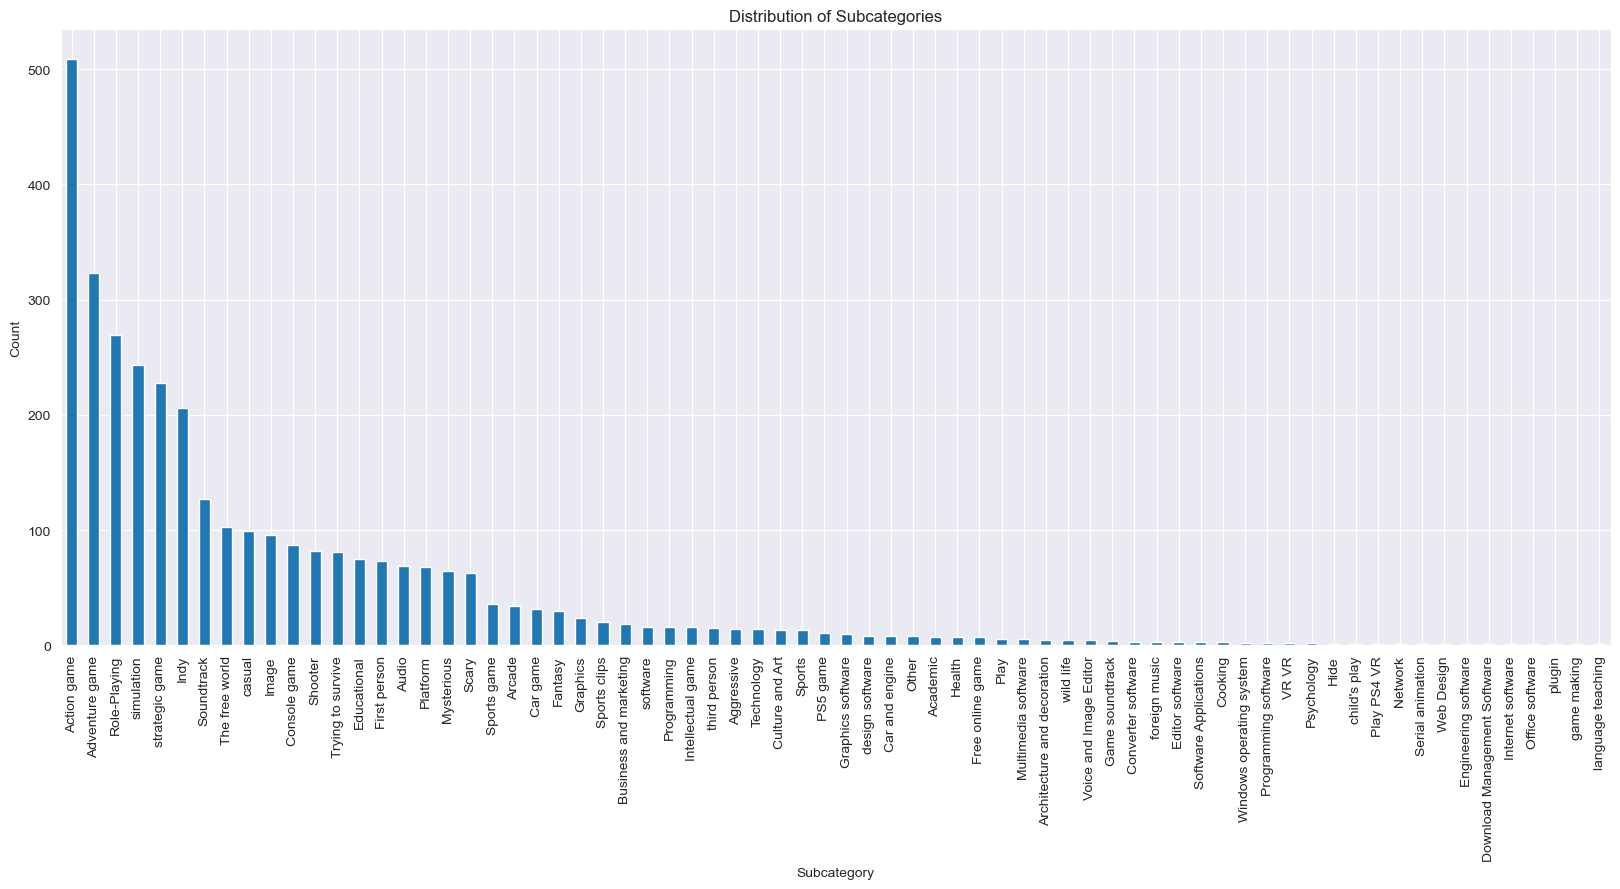

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV data into a DataFrame
df = pd.read_csv('game_data.csv')

# Extract and split the subcategories
subcategories = df['Categories'].str.split(', ', expand=True).stack()

# Plotting the distribution of subcategories
plt.figure(figsize=(20, 8))
subcategories.value_counts().plot(kind='bar')
plt.title('Distribution of Subcategories')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show()


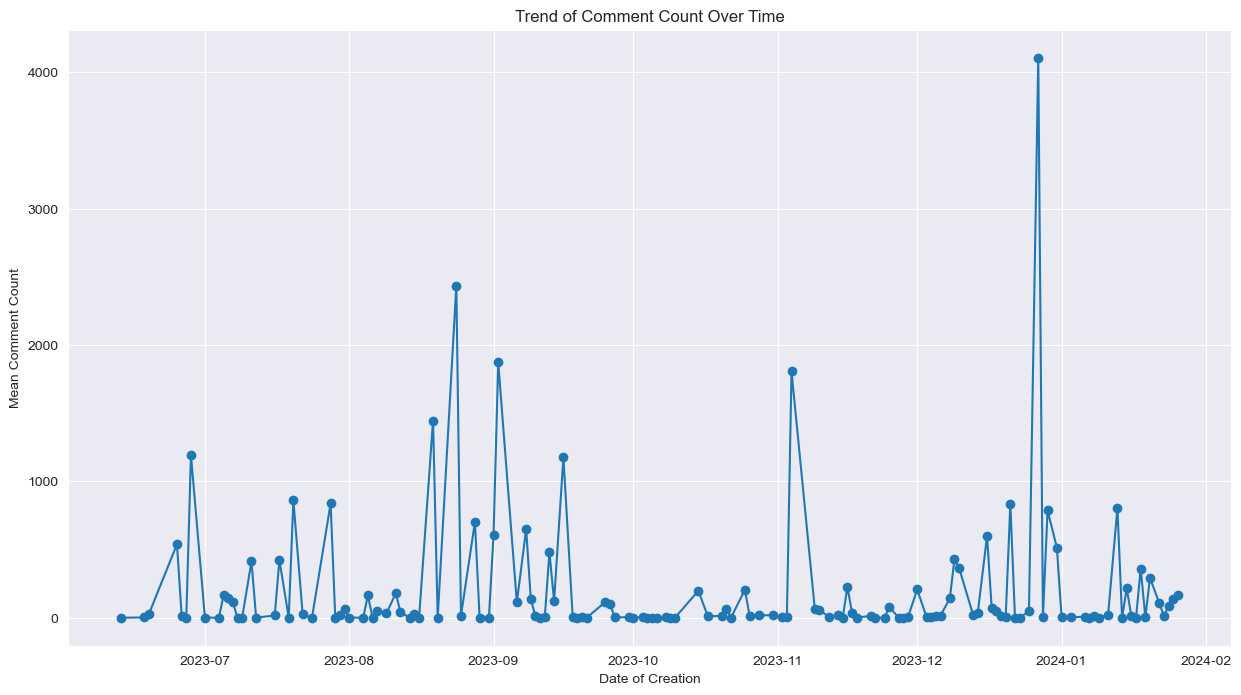

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV data into a DataFrame
df = pd.read_csv('game_data.csv')

# Convert 'Date of Creation' to datetime format
df['Date of Creation'] = pd.to_datetime(df['Date of Creation'], format='%Y-%m-%d')

# Remove commas from 'Comment Count' and convert to numeric
df['Comment Count'] = pd.to_numeric(df['Comment Count'].str.replace(',', ''), errors='coerce')

# Group by date and calculate the mean Comment Count for each date
comment_count_by_date = df.groupby('Date of Creation')['Comment Count'].sum()

# Plotting the trend of 'Comment Count' over time with a line plot
plt.figure(figsize=(15, 8))
plt.plot(comment_count_by_date.index, comment_count_by_date.values, marker='o')
plt.title('Trend of Comment Count Over Time')
plt.xlabel('Date of Creation')
plt.ylabel('Mean Comment Count')
plt.show()

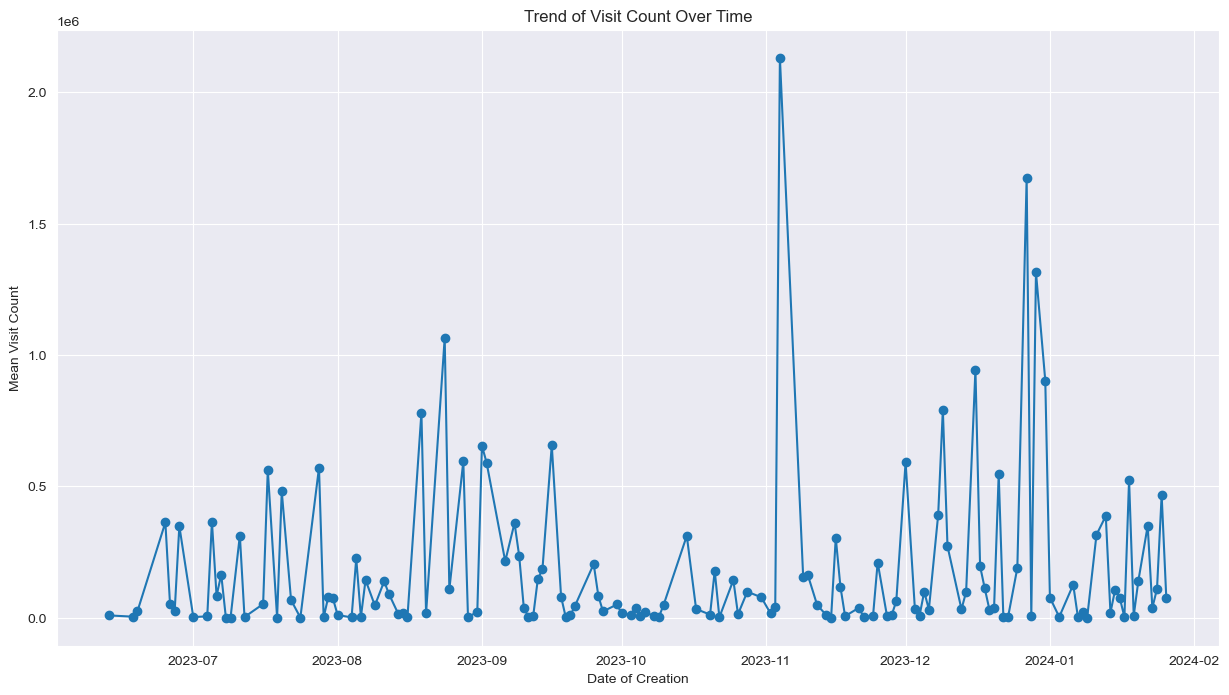

In [ ]:
# Remove commas from 'Comment Count' and convert to numeric
df['Visit Count'] = pd.to_numeric(df['Visit Count'], errors='coerce')

# Group by date and calculate the mean Comment Count for each date
comment_count_by_date = df.groupby('Date of Creation')['Visit Count'].sum()

# Plotting the trend of 'Comment Count' over time with a line plot
plt.figure(figsize=(15, 8))
plt.plot(comment_count_by_date.index, comment_count_by_date.values, marker='o')
plt.title('Trend of Visit Count Over Time')
plt.xlabel('Date of Creation')
plt.ylabel('Mean Visit Count')
plt.show()

- Frequency of softwares provided for different Platforms and operating systems including but not limited to PS5, Windows, Linux, MacOS X.

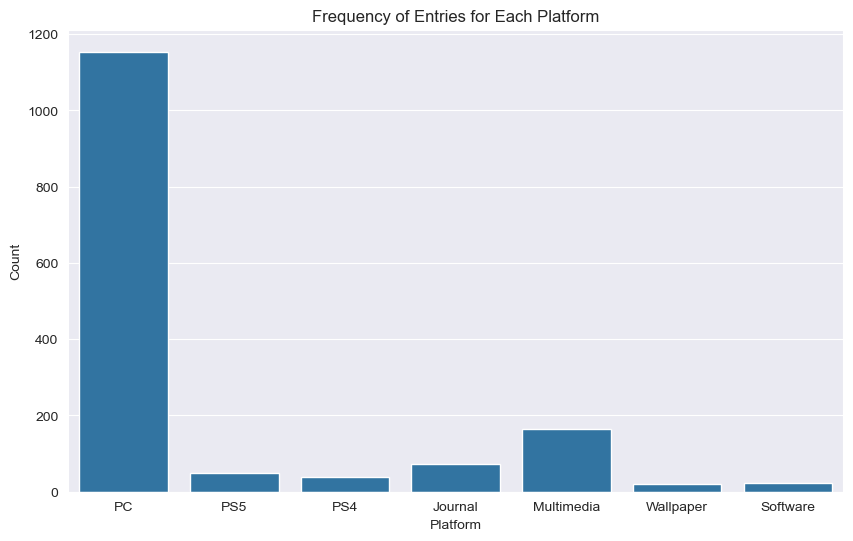

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV data into a DataFrame
df = pd.read_csv('game_data.csv')

# Plotting the number of entries for each Platform
plt.figure(figsize=(10, 6))
sns.countplot(x='Platform', data=df)
plt.title('Frequency of Entries for Each Platform')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.show()


## 3 Classification Beyond the Website

Now its time to extract the insights we need. For this part, you are free to use whichever technique, algorithm and library you desire. Just remember that the notebook should be able to provide the result locally, so avoid using online systems. Deliver the following items:

- Classify different categories of software and identify the top 5 hottest software categories and subcategories on the website based on the number of reviews and visits of softwares in that category. Explain your process and reasoning along with your results.

### Based on Mean reviews and visits for the category

In [ ]:
import pandas as pd

# Load the CSV data into a DataFrame and perform required operations
top_5_hottest = (
    pd.read_csv('game_data.csv')
    .assign(
        Comment_Count=lambda x: pd.to_numeric(x['Comment Count'].str.replace(',', ''), errors='coerce'),
        Visit_Count=lambda x: pd.to_numeric(x['Visit Count'], errors='coerce'),
        Categories=lambda x: x['Categories'].str.split(', ')
    )
    .explode('Categories')
    .groupby('Categories')
    .agg(
        Hotness=('Comment_Count', 'sum'),
        Comment_Count=('Comment_Count', 'mean'),
        Visit_Count=('Visit_Count', 'mean')
    )
    .assign(Hotness=lambda x: 20 * x['Comment_Count'] + x['Visit_Count'])
    .nlargest(5, 'Hotness')
)

top_5_hottest.head()


,Hotness,Comment_Count,Visit_Count
Categories,,,
Serial animation,2167100.0,1806.0,2130980.0
Download Management Software,850440.0,520.0,840040.0
Internet software,850440.0,520.0,840040.0
Office software,755246.0,219.0,750866.0
Windows operating system,501766.5,1660.0,468566.5


### Based on Total reviews and visits for the category

In [ ]:
import pandas as pd

# Load the CSV data into a DataFrame and perform required operations
top_5_hottest = (
    pd.read_csv('game_data.csv')
    .assign(
        Comment_Count=lambda x: pd.to_numeric(x['Comment Count'].str.replace(',', ''), errors='coerce'),
        Visit_Count=lambda x: pd.to_numeric(x['Visit Count'], errors='coerce'),
        Categories=lambda x: x['Categories'].str.split(', ')
    )
    .explode('Categories')
    .groupby('Categories')
    .agg(
        Hotness=('Comment_Count', 'sum'),
        Comment_Count=('Comment_Count', 'sum'),
        Visit_Count=('Visit_Count', 'sum')
    )
    .assign(Hotness=lambda x: 20 * x['Comment_Count'] + x['Visit_Count'])
    .nlargest(5, 'Hotness')
)

top_5_hottest.head()

,Hotness,Comment_Count,Visit_Count
Categories,,,
Action game,11551329,16127,11228789
Adventure game,5594955,6764,5459675
simulation,4801425,3120,4739025
The free world,4035201,4906,3937081
Role-Playing,3922369,4714,3828089


I have written two cases of code which one of them sorts the categories based on their total comments and views and the other sorts based on the mean of comments and views per post.(to not considering ones that are more frequent as hotter)

Also, I used a formula to sort the categories based on a special score, which is the sum of view counts and comment counts by a factor of 20 to give more weight to that because emphasises more importance.

Here is what I did in my code to do so:

1. **Data Cleaning:**
   - `assign` is used to create new columns for 'Comment_Count', 'Visit_Count', and 'Categories', where 'Comment_Count' is converted to numeric format, 'Visit_Count' is converted to numeric format, and 'Categories' is split into a list.

2. **Exploding Categories:**
   - The `explode` function is applied to the 'Categories' column, breaking down each list of categories into separate rows. This is done to have one category per row, making it easier to analyze.

3. **Grouping and Aggregating:**
   - The DataFrame is then grouped by 'Categories', and the `agg` function is used to calculate the mean of 'Comment_Count' and the sum of both 'Comment_Count' and 'Visit_Count' for each category.

4. **Hotness Calculation:**
   - A new column 'Hotness' is created by assigning a weight of 20 to 'Comment_Count' and adding it to 'Visit_Count'. This is done to give more weight to comments in the hotness measurement.

5. **Top 5 Categories:**
   - The `nlargest` function is used to get the top 5 categories based on the 'Hotness' score. The resulting DataFrame, `top_5_categories`, is then printed.



- Your team wants to contact the admins of the website directly. Using the `author` field you gathered previously, find out which individuals are responsible for posting softwares of different categories. This is done by matching the authors with categories and finding out the `author`s most responsible for the latest posts in different categories. As an example, you may find that 70 percent of PS5 action games are posted by **John Doe**, so it is probable that this individual is tasked with finding out the latest games of PS5 and posting them on the website.

In [ ]:
import pandas as pd

# Load the data
df = pd.read_csv('game_data.csv')

# Mapping for author names
Author_mapping = {
    'بهنام': 'Behnam',
    'حسین': 'Hossein',
    'حمید': 'Hamid',
    'sajjad6988': 'Sajjad6988'
}
df['Author'] = df['Author'].map(Author_mapping)

# Split Categories and explode into separate rows
df['Categories'] = df['Categories'].str.split(',')
df_expanded = df.explode('Categories')

# Calculate Count and Category_Frequency
grouped_df = df_expanded.groupby(['Categories', 'Author']).size().reset_index(name='Count')
grouped_df['Category_Frequency'] = grouped_df['Categories'].map(df_expanded['Categories'].value_counts())

# Sort the DataFrame
sorted_df = grouped_df.sort_values(['Category_Frequency', 'Count'], ascending=[False, False])

# Calculate Contribution Percentage
sorted_df['Contribution_Percentage'] = (
    sorted_df['Count'] / sorted_df.groupby('Categories')['Count'].transform('sum') * 100
)

# Display the result
sorted_df.head(10)


,Categories,Author,Count,Category_Frequency,Contribution_Percentage
80,Action game,Behnam,249,341,73.020528
82,Action game,Hossein,91,341,26.686217
81,Action game,Hamid,1,341,0.293255
43,Role-Playing,Behnam,181,227,79.735683
44,Role-Playing,Hossein,46,227,20.264317
3,Adventure game,Behnam,153,207,73.913043
5,Adventure game,Hossein,53,207,25.603865
4,Adventure game,Hamid,1,207,0.483092
144,strategic game,Behnam,147,196,75.000000
145,strategic game,Hossein,48,196,24.489796


- Find out and list five the sources you think the softwares and videos of the website are gathered from. Since `downloadha.com` is not a producer nor a developer, its objective is gathering different softwares from different vendors in one place. And it is most likely that it uses other websites as its source. Using the descriptions and analyzing it for entity names, it is possible to extract useful information about its possible sources. Explain your approach comprehensively and present your results.

In [22]:
import pandas as pd
from spacy.lang.en import English
from collections import Counter
import spacy
from bs4 import BeautifulSoup

# Load the CSV data into a DataFrame
df = pd.read_csv('game_data.csv')

# Load the small English model from spaCy for named entity recognition
nlp = spacy.load("en_core_web_sm")

# Set the display option to show a maximum of 1000 rows in the DataFrame
pd.set_option("display.max_rows", 1000)

# Initialize an empty list to store named entities (NER)
NER_list = []

# Iterate through the 'Description' column in the DataFrame
for i in range(len(df['Description'])):
    content = df['Description'][i]

    # Process the content using the spaCy NLP pipeline
    doc = nlp(content)

    # Extract named entities of type 'ORG' or 'PRODUCT' or those which have 'studio' in them and append them to the list
    for ent in doc.ents:
        if 'Studio' in ent.text.split() or ent.label_ == 'ORG' or ent.label_ == 'PRODUCT' or ent.label_ == 'PERSON':
            NER_list.append(ent.text)

# Count the occurrences of each named entity
count = Counter(NER_list)

# Get the most common named entities and their counts
most_common_NER = count.most_common()

print(most_common_NER)

[('RPG', 18), ('the Steam Network', 11), ('Rug Light', 11), ('Vikings', 7), ('Microsoft', 7), ('Apple', 7), ('Sonic', 7), ('PlayStation 2', 6), ('FIFA', 6), ('the Champions League', 6), ('Aphrodite', 5), ('JavaScript', 5), ('Nintendo', 5), ('iPhone', 5), ('Bayer', 4), ('House', 4), ('the Algerian Assembly', 4), ('GOG', 4), ('Sargon', 4), ('Disney', 4), ('linear', 4), ('PlayStation', 4), ('iPad', 4), ('Anthos', 4), ('Dead Cells', 4), ('Northgard', 3), ('Spirit', 3), ('Persion', 3), ('Sony', 3), ('IP', 3), ('Remaster', 3), ('Dahna', 3), ('Alfine and Shion', 3), ('NWO', 3), ('Xbox One', 3), ('Time', 3), ('Titanic', 3), ('DBT', 3), ('PDF', 3), ('RAW', 3), ('Sun', 3), ('Windows', 3), ('DLC', 3), ('Ninja', 3), ('Underrail', 3), ('IDM', 3), ('ERP', 3), ('Minecraft', 3), ('EpicStore', 3), ('MMO', 3), ('Sandbox', 3), ('BC', 3), ('Google Sheet', 3), ('WWE', 3), ('Palworld', 2), ('Norraz', 2), ('GPU', 2), ('The King of Fighters XV', 2), ('XV', 2), ('the Arts Electronic Simulator', 2), ('fifa', 2)

In this code, I have just processed the description for each row or in other words for each post and recognized all of its NER related to Organizations or Products. Then reported them sorted by their occurence.

The code employs spaCy's capabilities to recognize and analyze named entities in game descriptions, with a focus on organizations and products. The output reveals the most frequently mentioned entities, providing valuable information about the recurring themes in the dataset.

1. **Loading Libraries:**
   The necessary libraries, including spaCy, are imported. SpaCy is a natural language processing library that provides tools for various language-related tasks.

2. **Loading the SpaCy English Model:**
   The code loads a pre-trained English language model from spaCy. This model is capable of tokenization, part-of-speech tagging, and named entity recognition.

3. **Processing DataFrame Descriptions:**
   The code iterates through each game description in the DataFrame, applying the spaCy NLP pipeline to process the text. This involves tokenizing the text and identifying linguistic elements.

4. **Extracting Named Entities (NER):**
   For each processed description, the code identifies named entities. In this case, it focuses on entities labeled as 'ORG' (organization) or 'PRODUCT'. These entities represent names of organizations or products mentioned in the game descriptions.

5. **Counting Named Entities:**
   The code uses a Counter to keep track of the occurrences of each named entity. This step is essential for determining which entities are mentioned most frequently.

6. **Getting Most Common Named Entities:**
   The most common named entities are identified by sorting the Counter and extracting the entities with the highest occurrence counts. This provides insights into which organizations or products are frequently mentioned in the game descriptions.


   As you can see, the results are nearly all correct. The last step is to select five instances of those which can be a source for the downloadable files of website:

   1. the Steam Network (a broadband platform for direct software delivery and content management and allows you to purchase and immediately download the game)
   2. Microsoft
   3. Digital Photography Magazine
   4. Sky Game Studios
   5. Eleon Game Studios